In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.io import loadmat
import cv2
from PIL import Image
plt.style.use("seaborn")

In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## Modified model with VGG-19 Arhcitecture via Early-Exit block implementation on SVHN + GTSRB datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру (див. рис.1), але без використання Early-Exit блоку.

### Розроблена модель
Для проведення досліджень за основу було використано архітектуру згорткової нейронної мережі VGG-19. У модель, у якій реалізовано таку архітектуру, після першого блоку в згортковій основі було додано користувацький EЕ-блок (див. рис.2). Його головна мета полягяє у відсіюванні надлишкових зображень на ранніх етапах обчислень, щоб зекономити ресурси моделі при класифікації необхідних зображень. Ефективна реалiзацiя такої моделі на практицi дає змогу в наперед визначених місцях обчислювального графа динамічно обирати шлях під час отримання результату.

EE-блок створений на основі шарів максимізаційного агрегування (MaxPooling) та повністю зв'язних шарів (Fully-Connected, Dense), структура яких аналогічна до шарів у VGG-19 архітектурі. Також цей блок складається з шару, який вирівнює форму результату попереднього шару (Flatten). Це зроблено з метою застосування на останньому етапі повністю зв'язного шару, який на виході буде давати результат розподілу ймовірностей бінарної класифікації за допомогою функції активації $softmax$. Саме на цьому етапі модель буде визначати, чи зображення належить до надлишкового класу зображень, які не потребують подальшої класифікації.

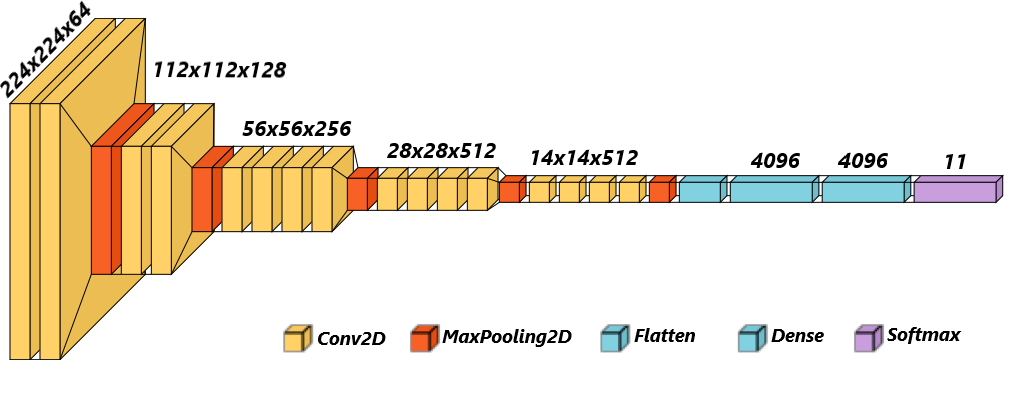
### *Рис.1: Модель на основі VGG-19 архітектури, використана у поданій роботі.*

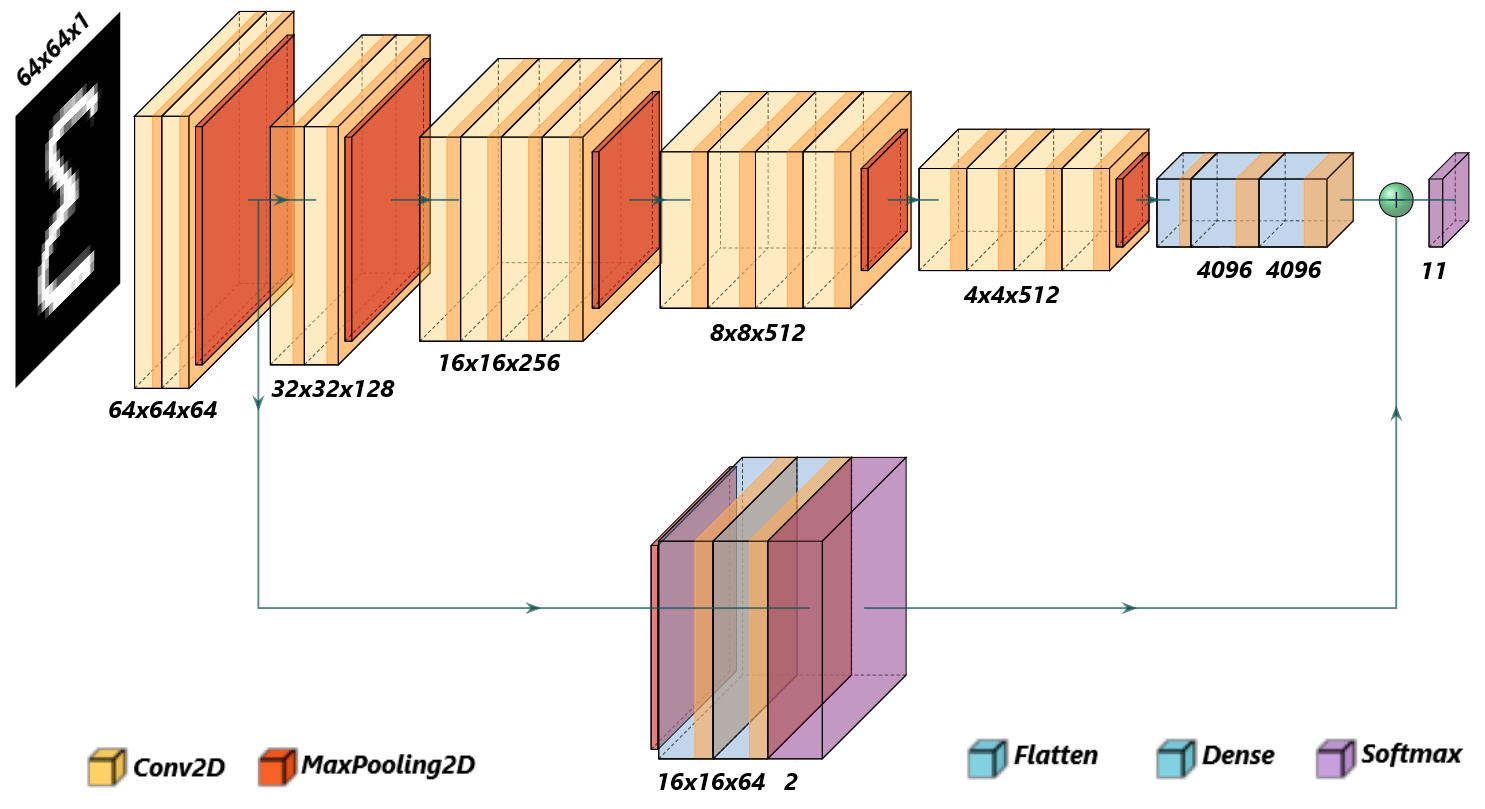
### *Рис.2: Модернізована модель на основі VGG-19 архітектури з реалізованим користувацьким EE-блоком.*

# Data preparation

## GTSRB

У ролі надлишкових даних було використано зображення з GTSRB (German Traffic Sign Recognition Benchmark) датасету. Цей набір даних представляє більше 50000 фотографій дорожніх знаків, які поділені на 43 класи. Зображення представлені у розмірі в межах 15х15 - 250х250 пікселів і подаються у форматі RGB. У поданій роботі було використано 10000 зображень для тренування та 6000 для тестування моделей. Усі зображення з наборів даних SVHN та GTSRB були нормалізовані та перетворені у формат 64х64 пікселі.

In [3]:
# Defined size for images for all datasets
img_height = 64
img_width = 64
channels = 3

In [4]:
# Paths to gtsrb
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

In [5]:
def preprocess_gtsrb(data_dir, train_path, test_path):
    X_gtsrb = []
    y_gtsrb = []
    X_gtsrb_test = []
    y_gtsrb_test = []

    NUM_CATEGORIES = len(os.listdir(train_path)) # 43

    for i in range(NUM_CATEGORIES):
        path = data_dir + '/Train/' + str(i)
        images = os.listdir(path)

        for img in images:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((img_height, img_width))
            X_gtsrb.append(np.array(resize_image))
            y_gtsrb.append(10)   # 10 stands for redundant class

    # Test data
    test = pd.read_csv(data_dir + '/Test.csv')
    imgs = test["Path"].values

    for img in imgs:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((img_height, img_width))
        X_gtsrb_test.append(np.array(resize_image))
        y_gtsrb_test.append(10)   # 10 stands for redundant class

    
    # Changing the list to numpy array
    X_gtsrb = np.array(X_gtsrb)
    y_gtsrb = np.array(y_gtsrb)
    X_gtsrb_test = np.array(X_gtsrb_test)
    y_gtsrb_test = np.array(y_gtsrb_test)
    
    # Assuming type is bfloat16
    X_gtsrb = X_gtsrb.astype('bfloat16')   #COMMENTED 04.02
    X_gtsrb_test = X_gtsrb_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_gtsrb = X_gtsrb / 255
    X_gtsrb_test = X_gtsrb_test / 255
    
    X_gtsrb, y_gtsrb = shuffle(X_gtsrb, y_gtsrb)
    X_gtsrb_test, y_gtsrb_test = shuffle(X_gtsrb_test, y_gtsrb_test)
    
    return X_gtsrb[:10000], y_gtsrb[:10000], X_gtsrb_test[:6000], y_gtsrb_test[:6000]

In [6]:
X_gtsrb, y_gtsrb, X_gtsrb_test, y_gtsrb_test = preprocess_gtsrb(data_dir, train_path, test_path)

from IPython.display import clear_output
clear_output()

In [7]:
print(f"X_gtsrb shape: {X_gtsrb.shape}")
print(f"y_gtsrb shape: {y_gtsrb.shape}")
print(f"X_gtsrb_test shape: {X_gtsrb_test.shape}")
print(f"y_gtsrb_test shape: {y_gtsrb_test.shape}")

X_gtsrb shape: (10000, 64, 64, 3)
y_gtsrb shape: (10000,)
X_gtsrb_test shape: (6000, 64, 64, 3)
y_gtsrb_test shape: (6000,)


## SVHN

Набір даних SVHN (Street View House Numbers), який представляє фотографії будинкових номерів,  містить 73257 зображень для тренування та 26032 для тестування моделі. Цей датасет є наближеним до MNIST, оскільки складається із зображень 10 класів цифр. Зображення будуть використовуватись у ролі головних і в даному датасеті подаються з розміром 32х32 пікселі у форматі RGB. Для проведення досліджень буде використовуватись 50000 зображень для тренування та 15000 для тестування.

In [8]:
def preprocess_svhn(train_raw, test_raw):
    # Load images and labels
    X_svhn = np.array(train_raw['X'])
    X_svhn_test = np.array(test_raw['X'])

    y_svhn = train_raw['y']
    y_svhn_test = test_raw['y']
    
    # Fix the axes of the images
    X_svhn = np.moveaxis(X_svhn, -1, 0)
    X_svhn_test = np.moveaxis(X_svhn_test, -1, 0)
    
    y_svhn = np.squeeze(y_svhn)
    y_svhn_test = np.squeeze(y_svhn_test)
    
    # Assuming type is bfloat16
    X_svhn = X_svhn.astype('bfloat16')   #COMMENTED 04.02
    X_svhn_test = X_svhn_test.astype('bfloat16')
    
    # Normalize images for better processing (values in range [0; 1])
    X_svhn = X_svhn / 255
    X_svhn_test = X_svhn_test / 255
    
    # Resize images from 32x32 to 64x64 (returns EagerTensor type)
    X_svhn = tf.image.resize_with_pad(
        image=X_svhn,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    X_svhn_test = tf.image.resize_with_pad(
        image=X_svhn_test,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    
    y_svhn = np.where(y_svhn != 10, y_svhn, 0)
    y_svhn_test = np.where(y_svhn_test != 10, y_svhn_test, 0)

    # Convert EagerTensor to numpy array
    X_svhn = X_svhn.numpy()
    X_svhn_test = X_svhn_test.numpy()
    
    X_svhn, y_svhn = shuffle(X_svhn, y_svhn)
    X_svhn_test, y_svhn_test = shuffle(X_svhn_test, y_svhn_test)
    
    return X_svhn[:50000], y_svhn[:50000], X_svhn_test[:15000], y_svhn_test[:15000]

In [9]:
# Load train and test data for svhn
train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [10]:
X_svhn, y_svhn, X_svhn_test, y_svhn_test = preprocess_svhn(train_raw, test_raw)

from IPython.display import clear_output
clear_output()

In [11]:
print(f"X_svhn shape: {X_svhn.shape}")
print(f"y_svhn shape: {y_svhn.shape}")
print(f"X_svhn_test shape: {X_svhn_test.shape}")
print(f"y_svhn_test shape: {y_svhn_test.shape}")

X_svhn shape: (50000, 64, 64, 3)
y_svhn shape: (50000,)
X_svhn_test shape: (15000, 64, 64, 3)
y_svhn_test shape: (15000,)


## Subclassing implementaion

### *Діаграма класів, використаних у поданій роботі*
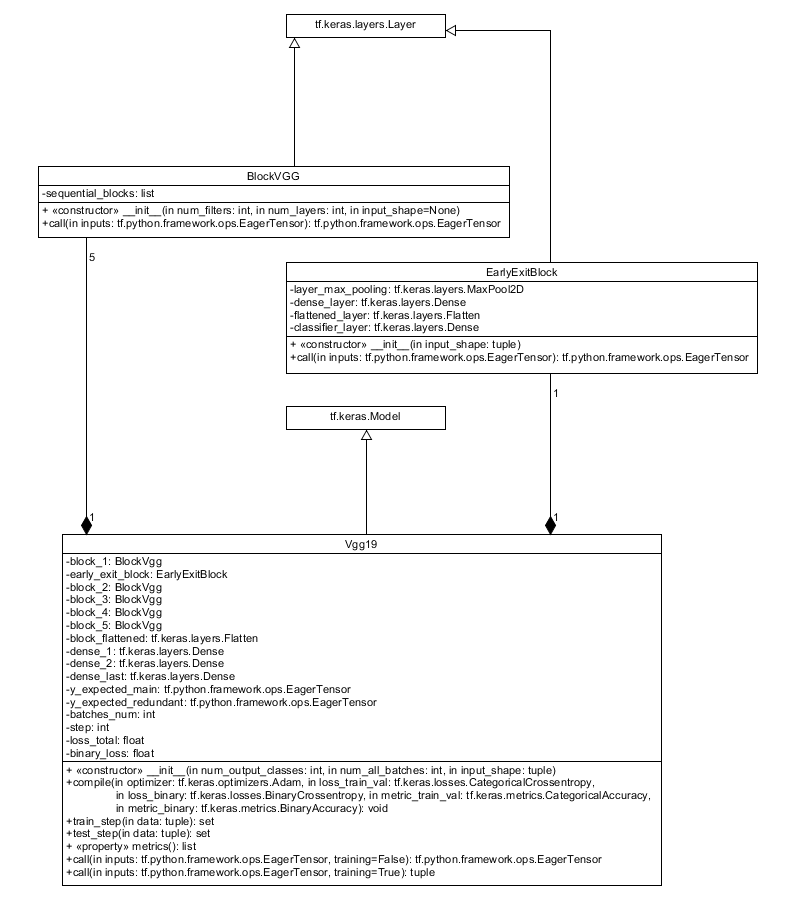

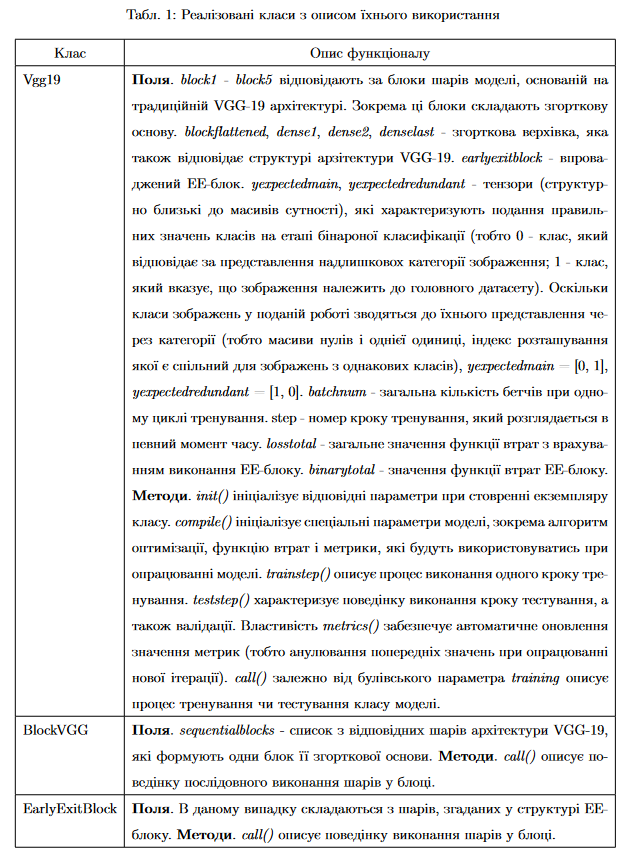

In [12]:
class BlockVgg(tf.keras.layers.Layer):
  def __init__(self, *, num_filters: int, num_layers: int, input_shape=None):
    super().__init__()
    self.sequential_blocks = []
    for num_layer in range(num_layers):
      if input_shape is not None:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, input_shape=input_shape, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
      else:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
    self.sequential_blocks.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
  
  def call(self, inputs):
    output = self.sequential_blocks[0](inputs)
    for layer in self.sequential_blocks[1:]:
      output = layer(output)
    
    return output

In [13]:
class EarlyExitBlock(tf.keras.layers.Layer):
  def __init__(self, input_shape):
    super().__init__()
    self.layer_max_pooling = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.dense_layer = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())
    self.flattened_layer = tf.keras.layers.Flatten()
    self.classifier_layer = tf.keras.layers.Dense(2, activation=tf.keras.layers.Softmax())
  

  def call(self, inputs):
    output = self.layer_max_pooling(inputs)
    output = self.flattened_layer(output)
    output = self.dense_layer(output)
    output = self.classifier_layer(output)

    return output


In [14]:
class Vgg19(tf.keras.Model):
  def __init__(self, num_output_classes: int, input_shape) -> None:
    super().__init__()

    self.block_1 = BlockVgg(num_filters=64, num_layers=2, input_shape=input_shape)

    self.early_exit_block = EarlyExitBlock(input_shape=(input_shape[0]/2, 
                                                        input_shape[1]/2))

    self.block_2 = BlockVgg(num_filters=128, num_layers=2)
    self.block_3 = BlockVgg(num_filters=256, num_layers=4)
    self.block_4 = BlockVgg(num_filters=512, num_layers=4)
    self.block_5 = BlockVgg(num_filters=512, num_layers=4)
        
    self.block_flattened = tf.keras.layers.Flatten()

    self.dense_1 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_2 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_last = tf.keras.layers.Dense(num_output_classes, activation='softmax')
    
    # Variables for calculating loss
    self.NON_PHOTO = 0
    self.IS_PHOTO = 1

    self.y_expected_svhn = tf.one_hot([self.IS_PHOTO], 2)
    self.y_expected_gtsrb = tf.one_hot([self.NON_PHOTO], 2)
    
    self.step = 0
    self.loss_total = 0
    self.binary_loss = 0
    
    
    
  def compile(self, optimizer, loss_train_val, loss_binary, metric_train_val, metric_binary):
    super(Vgg19, self).compile()
    # Optimizer
    self.optimizer = optimizer

    # Losses
    self.compiled_loss = loss_train_val
    self.binary_crossentropy_loss = loss_binary

    # Metrics
    self.compiled_metrics = metric_train_val
    self.binary_acc_metric = metric_binary
    
    # Metrics for tracking losses
    self.loss_tracker_train = tf.keras.metrics.Mean()
    self.loss_tracker_val = tf.keras.metrics.Mean()
    self.loss_tracker_binary = tf.keras.metrics.Mean()
    
    
    
  # Train step used in .fit(X, y) 
  def train_step(self, data):     # should be (x, y)
    x_current_batch, y_current_batch = data
    
    with tf.GradientTape() as tape:

      # feed first svhn, then gtsrb

      if self.step % 6 != 0:   # (int(times_datasets_differ_in) + 1) * num_batches_gtsrb = 750
        # print('svhn')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)  # training true parameter
        output_expected = y_current_batch

        # 10 classes classification loss
        loss_classification = self.compiled_loss(output_expected, classification_output_actual)

        # early exit classification loss for svhn
        y_expected_svhn_batch = tf.repeat(self.y_expected_svhn, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_svhn_batch, early_exit_output_actual)

        # taking average of these losses in case this is PHOTO value
        self.loss_total = loss_classification + loss_early_exit
        
        # calculate binary loss within svhn (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_svhn_batch, early_exit_output_actual)

        # update training metric for svhn (EE + classification)
        self.compiled_metrics.update_state(y_expected_svhn_batch, early_exit_output_actual)
        self.compiled_metrics.update_state(output_expected, classification_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_svhn_batch, early_exit_output_actual)

      else:
        # print('gtsrb')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)    # training true parameter
        output_expected = y_current_batch

        # in case of non-PHOTO class we don't calculate loss for 10 classes classification  part of network
        # this may produce warnings from tensorflow, check the names of the layers and if they are as expected, just ignore this warning

        y_expected_gtsrb_batch = tf.repeat(self.y_expected_gtsrb, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_gtsrb_batch, early_exit_output_actual)

        # take loss only for early-exit block
        self.loss_total = loss_early_exit
        
        # calculate binary loss within gtsrb (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_gtsrb_batch, early_exit_output_actual)

        # update training metric for svhn (only EE)
        self.compiled_metrics.update_state(y_expected_gtsrb_batch, early_exit_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_gtsrb_batch, early_exit_output_actual)

    # choose correct weights here
    weights = self.trainable_weights

    gradients = tape.gradient(self.loss_total, weights)
    self.optimizer.apply_gradients(zip(gradients, weights))
    
    self.loss_tracker_train.update_state(self.loss_total)
    self.loss_tracker_binary.update_state(self.binary_loss)
    
    self.step += 1
    
    if self.step == 750:
        self.step = 0

    return {"Training loss": self.loss_tracker_train.result(), "Training acc": self.compiled_metrics.result(), "Binary loss": self.loss_tracker_binary.result(), "Binary acc": self.binary_acc_metric.result()}



  def test_step(self, data):
    x_batch, y_batch = data
    
    # Compute predictions
    output_actual = vgg_19_test(x_batch, training=False)

    # Calculate validation loss
    val_loss = self.compiled_loss(y_batch, output_actual)
    self.loss_tracker_val.update_state(val_loss)

    # Update val metrics
    self.compiled_metrics.update_state(y_batch, output_actual)
    
    self.step = 0
    
    return {"Validation loss": self.loss_tracker_val.result(), "Validation acc": self.compiled_metrics.result()}


    
  @property
  def metrics(self):
    # `Metric` objects here so that `reset_states()` can be called automatically at the start of each epoch or at the start of `evaluate()`
    return [self.compiled_metrics, self.binary_acc_metric, self.loss_tracker_train, self.loss_tracker_val, self.loss_tracker_binary]

    

  def call(self, inputs, training=None):
    typical_output = self.block_1(inputs)

    early_exit_output = self.early_exit_block(typical_output)

    if not training:
        output_for_val_or_test = np.empty([inputs.shape[0], 11])
        
        anticipated_svhn_or_gtsrb_result = np.argmax(early_exit_output, axis=1)     # 0 when NON_PHOTO; 1 when PHOTO
        indeces_for_gtsrb = np.argwhere(anticipated_svhn_or_gtsrb_result == 0)
        indeces_for_svhn = np.argwhere(anticipated_svhn_or_gtsrb_result == 1)
        num_of_svhn_in_batch = np.count_nonzero(anticipated_svhn_or_gtsrb_result)
        
        if len(indeces_for_gtsrb) > 0:
            # insert tensors defining gtsrb images for specific indeces, where gtsrb images were defined in EE
            np.put_along_axis(output_for_val_or_test, indeces_for_gtsrb, np.squeeze(tf.one_hot([10], 11)), axis=0)
            
        if len(indeces_for_svhn) == 0:
            #print("indeces_for_svhn IS EMPTY")
            return output_for_val_or_test
        
        # modify mnsit indeces
        indeces_for_svhn = np.squeeze(indeces_for_svhn, axis=1)
        
        # take to classificstion step only those images which are from svhn
        typical_output = np.take(typical_output, indeces_for_svhn, axis=0)
        

    typical_output = self.block_2(typical_output)
    typical_output = self.block_3(typical_output)
    typical_output = self.block_4(typical_output)
    typical_output = self.block_5(typical_output)

    typical_output = self.block_flattened(typical_output)

    typical_output = self.dense_1(typical_output)
    typical_output = self.dense_2(typical_output)
    typical_output = self.dense_last(typical_output)

    if training:
        return early_exit_output, typical_output
    else:
        # modify svhn indeces back
        indeces_for_svhn = np.expand_dims(indeces_for_svhn, axis=1)
        
        # insert tensors defining svhn images for specific indeces, where svhn images were defined in full vgg-19 classification
        np.put_along_axis(output_for_val_or_test, indeces_for_svhn, typical_output, axis=0)
        
        return output_for_val_or_test

# Subclassing usage

In [15]:
NON_PHOTO = 0
IS_PHOTO = 1

y_expected_svhn = tf.one_hot([IS_PHOTO], 2)
y_expected_gtsrb = tf.one_hot([NON_PHOTO], 2)

print(f"y_expected_svhn: {y_expected_svhn}; y_expected_gtsrb: {y_expected_gtsrb}")

y_expected_svhn: [[0. 1.]]; y_expected_gtsrb: [[1. 0.]]


In [16]:
X_gtsrb.shape[0]

10000

In [17]:
X_svhn.shape[0]

50000

## Train/Test split of datasets 

In [18]:
# Train / test (validation) split of svhn
X_svhn_train, X_svhn_val, y_svhn_train, y_svhn_val = train_test_split(X_svhn, y_svhn, train_size=0.8, test_size=0.2, random_state=0)

In [19]:
y_svhn_val.shape

(10000,)

In [20]:
# Train / test (validation) split of gtsrb
X_gtsrb_train, X_gtsrb_val, y_gtsrb_train, y_gtsrb_val = train_test_split(X_gtsrb, y_gtsrb, train_size=0.8, test_size=0.2, random_state=0)

In [21]:
y_gtsrb_train.shape

(8000,)

### Concatenation of svhn and gtsrb datasets for validation and testing step

In [22]:
X_svhn_gtsrb_val = np.concatenate((X_svhn_val, X_gtsrb_val), axis=0)
y_svhn_gtsrb_val = np.concatenate((y_svhn_val, y_gtsrb_val), axis=0)

X_svhn_gtsrb_test = np.concatenate((X_svhn_test, X_gtsrb_test), axis=0)
y_svhn_gtsrb_test = np.concatenate((y_svhn_test, y_gtsrb_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X_svhn_gtsrb_val, y_svhn_gtsrb_val = shuffle(X_svhn_gtsrb_val, y_svhn_gtsrb_val)
X_svhn_gtsrb_test, y_svhn_gtsrb_test = shuffle(X_svhn_gtsrb_test, y_svhn_gtsrb_test)

In [23]:
# 11 classes for validation and testing targets
y_svhn_gtsrb_val = tf.keras.utils.to_categorical(y_svhn_gtsrb_val)
y_svhn_gtsrb_test = tf.keras.utils.to_categorical(y_svhn_gtsrb_test)

In [24]:
print(f'Validation: X={X_svhn_gtsrb_val.shape}, y={y_svhn_gtsrb_val.shape}')
print(f'Test: X={X_svhn_gtsrb_test.shape}, y={y_svhn_gtsrb_test.shape}')

Validation: X=(12000, 64, 64, 3), y=(12000, 11)
Test: X=(21000, 64, 64, 3), y=(21000, 11)


## Merge svhn and gtsrb datasets for training in right order

In [25]:
# For training
bs = 64
num_batches_svhn = int(X_svhn_train.shape[0]/bs)
num_batches_gtsrb =  int(X_gtsrb_train.shape[0]/bs)

times_datasets_differ_in = int(num_batches_svhn/num_batches_gtsrb)

In [26]:
num_batches_svhn, num_batches_gtsrb, times_datasets_differ_in

(625, 125, 5)

In [27]:
X_svhn_train_reshape = np.reshape(X_svhn_train, (num_batches_svhn, bs, 64,64,3)) 
X_svhn_train_reshape.shape

(625, 64, 64, 64, 3)

In [28]:
X_gtsrb_train_reshape = np.reshape(X_gtsrb_train, (num_batches_gtsrb, bs, 64,64,3)) 
X_gtsrb_train_reshape.shape

(125, 64, 64, 64, 3)

In [29]:
X_svhn_gtsrb_train = np.insert(X_svhn_train_reshape, np.arange(0, num_batches_gtsrb*times_datasets_differ_in, times_datasets_differ_in), X_gtsrb_train_reshape, axis=0)

In [30]:
y_svhn_train_reshape = np.reshape(y_svhn_train, (num_batches_svhn, bs)) 
y_svhn_train_reshape.shape

(625, 64)

In [31]:
y_gtsrb_train_reshape = np.reshape(y_gtsrb_train, (num_batches_gtsrb, bs)) 
y_gtsrb_train_reshape.shape

(125, 64)

In [32]:
y_svhn_gtsrb_train = np.insert(y_svhn_train_reshape, np.arange(0, num_batches_gtsrb*times_datasets_differ_in, times_datasets_differ_in), y_gtsrb_train_reshape, axis=0)

In [33]:
X_svhn_gtsrb_train.shape

(750, 64, 64, 64, 3)

In [34]:
# 11 classes for training targets as well
y_svhn_gtsrb_train = tf.keras.utils.to_categorical(y_svhn_gtsrb_train)

In [35]:
y_svhn_gtsrb_train.shape

(750, 64, 11)

In [36]:
# MAKE SHAPE (..., 64,64,1)
X_svhn_gtsrb_train = np.reshape(X_svhn_gtsrb_train, ((num_batches_gtsrb+num_batches_svhn)*bs,64,64,3)) 
X_svhn_gtsrb_train.shape

(48000, 64, 64, 3)

In [37]:
# MAKE SHAPE (..., 11)
y_svhn_gtsrb_train = np.reshape(y_svhn_gtsrb_train, ((num_batches_gtsrb+num_batches_svhn)*bs,11)) 
y_svhn_gtsrb_train.shape

(48000, 11)

In [38]:
num_batches_svhn

625

In [39]:
num_batches_gtsrb

125

In [40]:
X_svhn_gtsrb_train.shape

(48000, 64, 64, 3)

## Training and Evaluation

In [41]:
vgg_19_test = Vgg19(11, (img_height, img_width, 3))

In [42]:
vgg_19_test.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
                    loss_train_val=tf.keras.losses.CategoricalCrossentropy(),
                    loss_binary=tf.keras.losses.BinaryCrossentropy(),
                    metric_train_val=tf.keras.metrics.CategoricalAccuracy(),
                    metric_binary=tf.keras.metrics.BinaryAccuracy())

In [43]:
tf.config.run_functions_eagerly(True)

history_vgg_19_test = vgg_19_test.fit(
    X_svhn_gtsrb_train, y_svhn_gtsrb_train,
    validation_data=(X_svhn_gtsrb_val, y_svhn_gtsrb_val),
    batch_size=64,
    epochs=5,
    steps_per_epoch=num_batches_svhn+num_batches_gtsrb,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
750/750 [==============================] - 130s 154ms/step - Training loss: 2.2522 - Training acc: 0.5622 - Binary loss: 0.3373 - Binary acc: 0.8719 - val_Validation loss: 2.0299 - val_Validation acc: 0.3049
Epoch 2/5
750/750 [==============================] - 117s 156ms/step - Training loss: 1.9240 - Training acc: 0.6227 - Binary loss: 0.0668 - Binary acc: 0.9813 - val_Validation loss: 1.9352 - val_Validation acc: 0.3194
Epoch 3/5
750/750 [==============================] - 108s 145ms/step - Training loss: 1.8806 - Training acc: 0.6298 - Binary loss: 0.0246 - Binary acc: 0.9937 - val_Validation loss: 1.8750 - val_Validation acc: 0.3226
Epoch 4/5
750/750 [==============================] - 108s 143ms/step - Training loss: 1.8586 - Training acc: 0.6333 - Binary loss: 0.0091 - Binary acc: 0.9982 - val_Validation loss: 1.4010 - val_Validation acc: 0.5393
Epoch 5/5
750/750 [==============================] - 106s 141ms/step - Training loss: 1.0078 - Training acc: 0.8193 - Binary los

In [44]:
score_gtsrb_svhn = vgg_19_test.evaluate(X_svhn_gtsrb_test, y_svhn_gtsrb_test)
print('Test loss:', score_gtsrb_svhn[1])
print('Test score:', score_gtsrb_svhn[0])

print("CNN Error: %.2f%%" % (100-score_gtsrb_svhn[0]*100))

657/657 [==============================] - 26s 39ms/step - Validation loss: 0.6151 - Validation acc: 0.8031
Test loss: 0.6026512980461121
Test score: 0.805809497833252
CNN Error: 19.42%


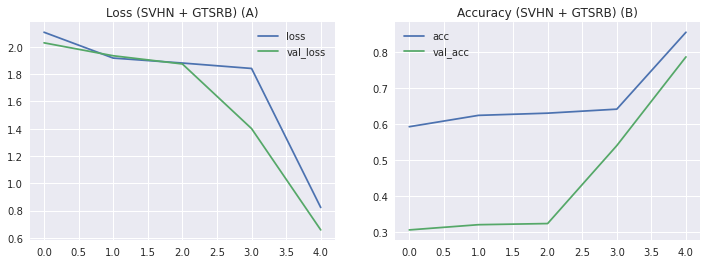

In [45]:
history_vgg_19_test_frame = pd.DataFrame(history_vgg_19_test.history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_19_test_frame['Training loss'], label='loss')
plt.plot(history_vgg_19_test_frame['val_Validation loss'], label='val_loss')
plt.title('Loss (SVHN + GTSRB) (A)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg_19_test_frame['Training acc'], label='acc')
plt.plot(history_vgg_19_test_frame['val_Validation acc'], label='val_acc')
plt.title('Accuracy (SVHN + GTSRB) (B)')
plt.legend()

## Prediction, inference time, confusion matrix

In [46]:
# GPU T4 x2, batch_size = 32 (default)
start_time = time.time()

#Predict y_test values for comparison in confusion matrix (gtsrb + svhn, 11 classes)
y_test_pred = vgg_19_test.predict(X_svhn_gtsrb_test)

elapsed = time.time() - start_time

y_test_true = y_svhn_gtsrb_test

In [47]:
print(f"Inference time for all samples (batch_size=64) : {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (gtsrb + svhn dataset, 11 classes): {np.round(elapsed / len(X_svhn_gtsrb_test), 6)} sec.")

Inference time for all samples (batch_size=64) : 18.433041 sec.
Average inference time for 1 sample (gtsrb + svhn dataset, 11 classes): 0.000878 sec.


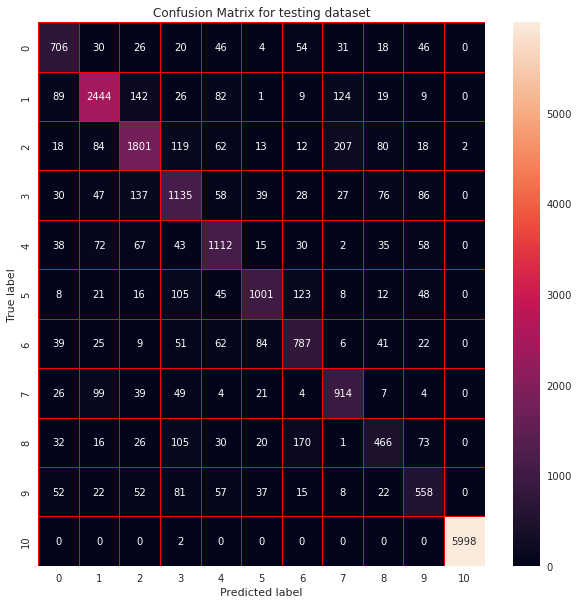

In [48]:
#Confusion matrix for svhn + gtsrb evaluation data
gtsrb_svhn_cm=confusion_matrix(y_test_true.argmax(axis=1), y_test_pred.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(gtsrb_svhn_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.title('Confusion Matrix for testing dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Other metrics nad results

In [49]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
labels.append("Sign")

def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

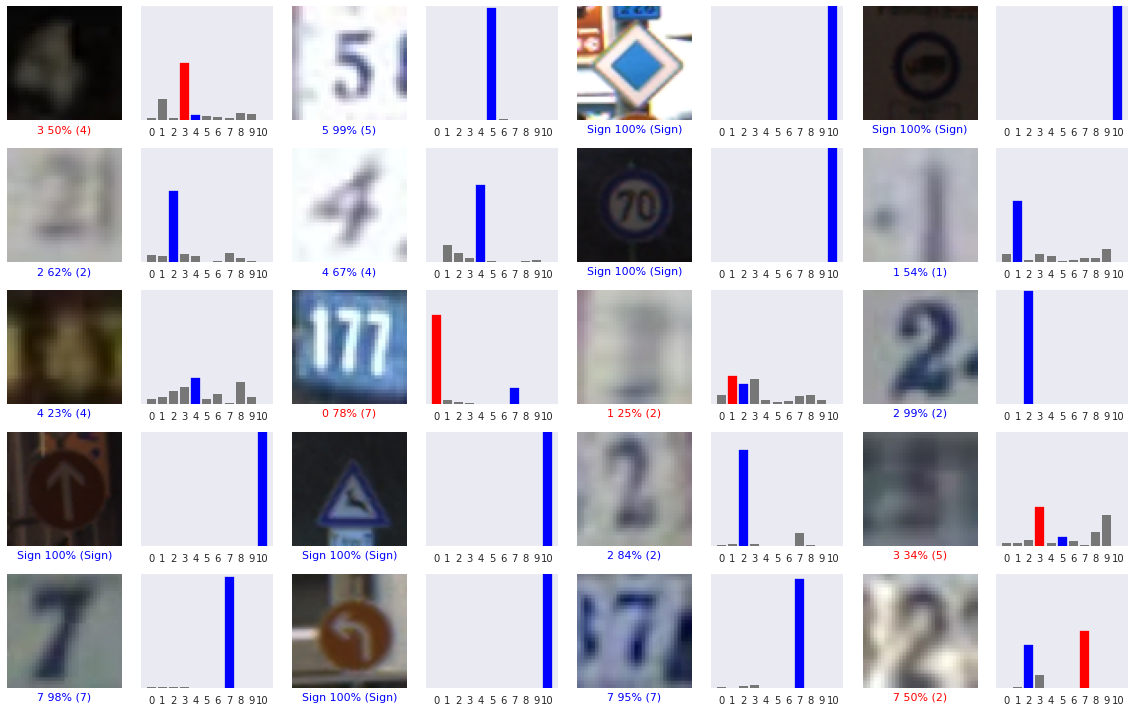

In [50]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
X_svhn_gtsrb_test = X_svhn_gtsrb_test.astype("float32")
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred[i+20], y_test_true[i+20], X_svhn_gtsrb_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i+20], y_test_true[i+20])
plt.tight_layout()
plt.show()